## Imports

Import required libraries.

In [1]:
import scipy.io
import mne
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Preprocessing

### Load data
Load raw EEG data for normal state of *Person 1* from .cnt file and display general information about data.

In [2]:
file_name = "data/1/Normal state.cnt"
raw_normal = mne.io.read_raw_cnt(file_name, preload=True, verbose=False).load_data()

<ipython-input-2-cc4a196f5063>:2: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  raw_normal = mne.io.read_raw_cnt(file_name, preload=True, verbose=False).load_data()
<ipython-input-2-cc4a196f5063>:2: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw_normal = mne.io.read_raw_cnt(file_name, preload=True, verbose=False).load_data()


In [3]:
raw_normal.info

<Info | 8 non-empty values
 bads: []
 ch_names: HEOL, HEOR, FP1, FP2, VEOU, VEOL, F7, F3, FZ, F4, F8, FT7, FC3, ...
 chs: 40 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: unspecified
 nchan: 40
 projs: []
 sfreq: 1000.0 Hz
 subject_info: 5 items (dict)
>

Display PSD chart. A Power Spectral Density (PSD) is the measure of signal's power content versus frequency.

<ipython-input-4-7a97954e97b1>:1: UserWarning: Infinite value in PSD for channels HEOR, FP2, F3, FT8, C3, C4, TP7, TP8, PZ, PO2.
These channels might be dead.
  raw_normal.plot_psd()


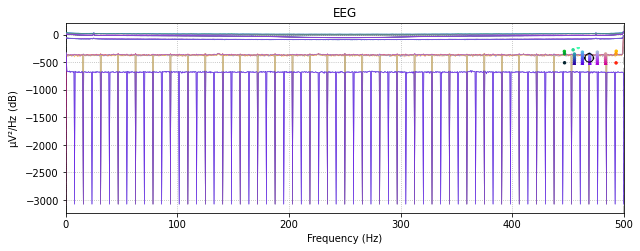

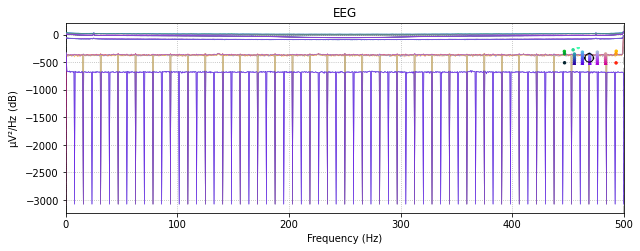

In [4]:
raw_normal.plot_psd()

### Crop signal

The original signal duration is ten minutes. Cut out the first five mintues as paper states only the last five minutes is used. Also, shift signal to the left because of the noise at the end.

In [5]:
raw_normal.crop(tmin=250, tmax=550)

<RawCNT | Normal state.cnt, 40 x 300001 (300.0 s), ~91.6 MB, data loaded>

### Clean channels
Extract channels mentioned in the paper, remove all other channels from the dataset.
After this step, only ten EEG channels should remain.

In [6]:
goods_ch = set(["T6", "P3", "TP7", "O1", "OZ", "T4", "T5", "FCZ", "FC3", "CP3"])
all_ch = set(raw_normal.info["ch_names"])
bads_ch = list(all_ch - goods_ch)

raw_normal.info["bads"].extend(bads_ch)

In [7]:
raw_normal.info

<Info | 9 non-empty values
 bads: 30 items (C4, PZ, FT7, FZ, P4, FP1, FC4, O2, HEOR, PO1, F4, T3, ...)
 ch_names: HEOL, HEOR, FP1, FP2, VEOU, VEOL, F7, F3, FZ, F4, F8, FT7, FC3, ...
 chs: 40 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: unspecified
 nchan: 40
 projs: []
 sfreq: 1000.0 Hz
 subject_info: 5 items (dict)
>

### Filter
Apply notch filter to remove power-line noise. Power-line noise is a noise created by the electrical network and it is composed of sharp peaks at 50Hz. Some peaks may also be present at the harmonic frequencies, i.e. the integer multiples of the power-line frequency, e.g. 100Hz, 150Hz ...

In [8]:
picks = mne.pick_types(raw_normal.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads')

raw_normal.notch_filter(np.arange(50, 251, 50), picks=picks)

<RawCNT | Normal state.cnt, 40 x 300001 (300.0 s), ~91.6 MB, data loaded>

Display PSD chart after applying the notch filter.

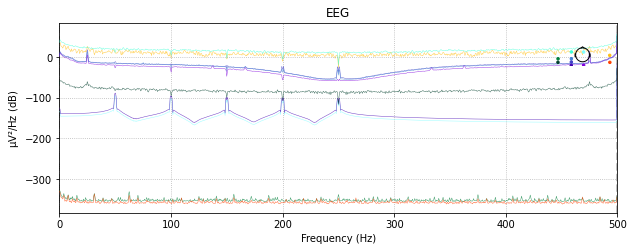

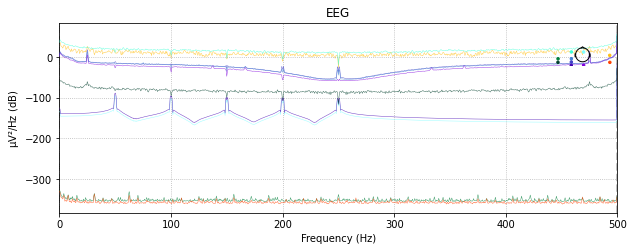

In [9]:
raw_normal.plot_psd()

Apply band pass filter to remove the noise.

In [10]:
freq1 = 0.15
freq2 = 40
raw_normal.filter(freq1, freq2)

<RawCNT | Normal state.cnt, 40 x 300001 (300.0 s), ~91.6 MB, data loaded>

Display PSD chart after applying the band pass filter.

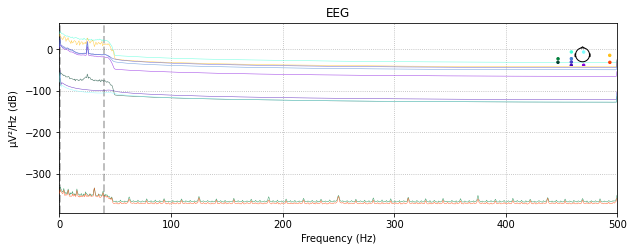

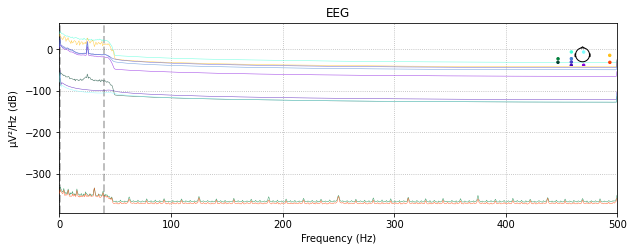

In [11]:
raw_normal.plot_psd()

Display the raw data plot after preprocessing.

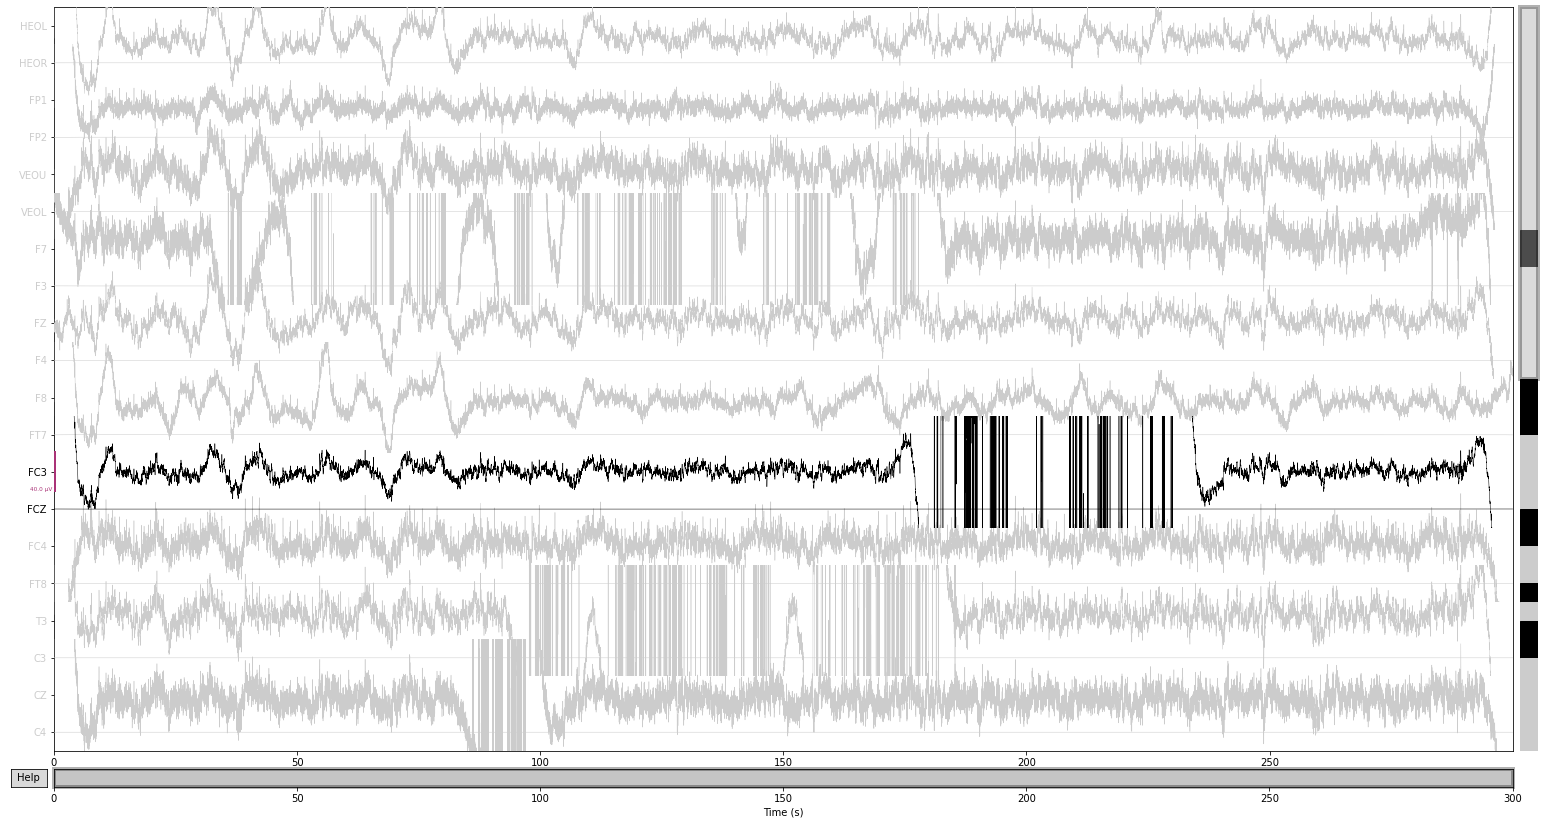

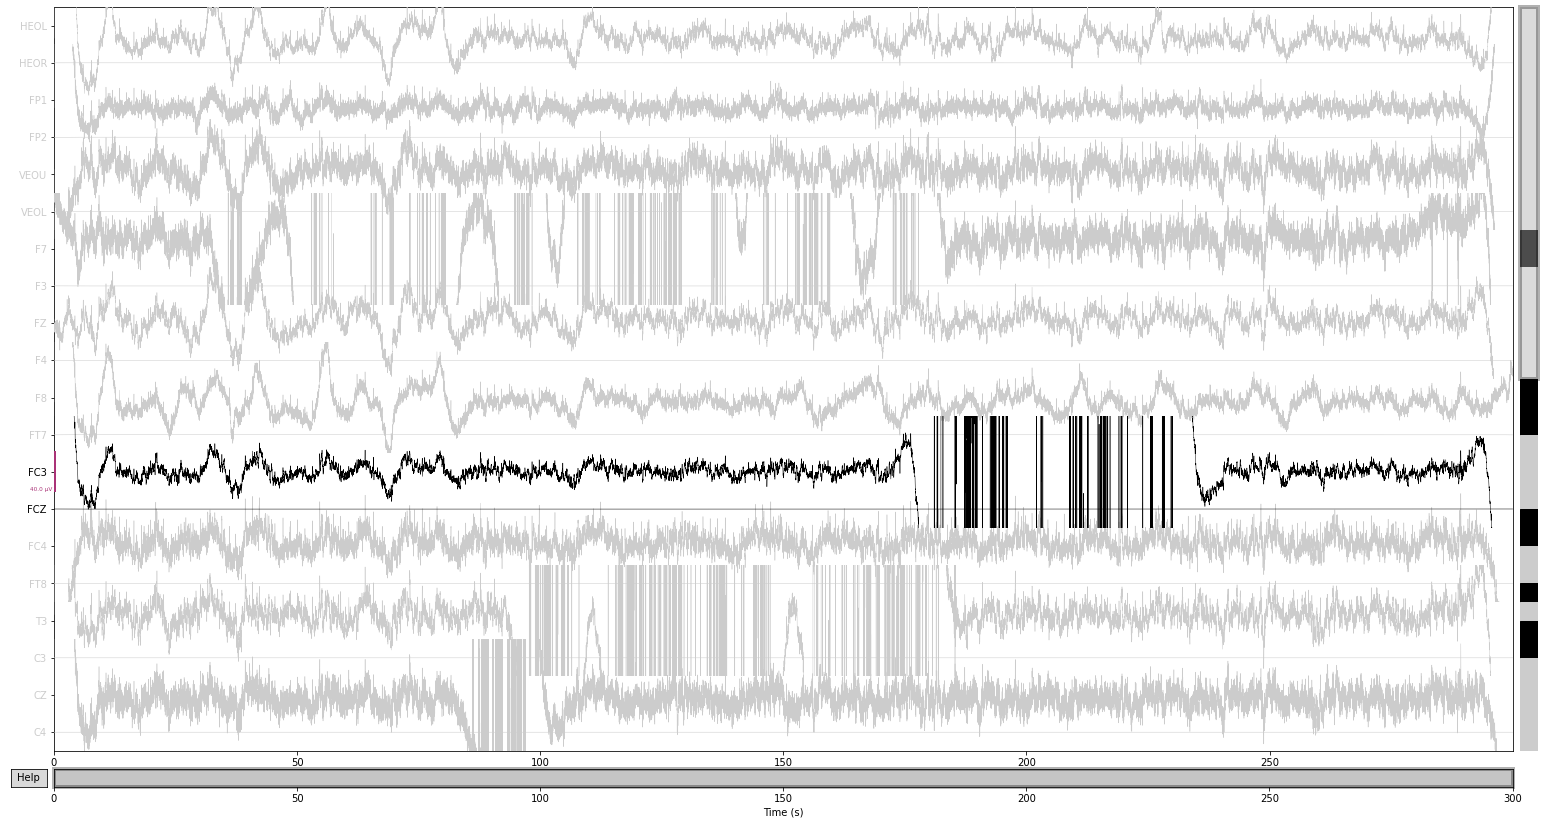

In [12]:
raw_normal.plot(start=0, duration=300, show=True)